In [64]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [ ]:
pip install -U scikit-learn

In [65]:
#Imports

import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_log_error,mean_absolute_error,r2_score, make_scorer
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import cross_val_score
import joblib

In [66]:
train_df = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', encoding='utf-8')
test_df = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', encoding='utf-8')


In [67]:
print(f'Train dataset contains, {train_df.shape[0]} rows and {train_df.shape[1]} columns')
train_df.head()

Train dataset contains, 1460 rows and 81 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [68]:
print(f'Test dataset contains {test_df.shape[0]} rows and {test_df.shape[1]} columns')
test_df.head()

Test dataset contains 1459 rows and 80 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


At a first glance, we have multiple columns that contains missing values; let's started focusing on the train dataframe where it contains our target variable `SalePrice`.

With an overall look, we can see that the first House sold was in 2006 and the oldest house was builded in 1872. Apart from that, there are plenty of columns where the max value reached is more than the double of the 3rd percentile; that could be a sign of outlier but is something to discuss later.
This method retrieve 38 columns, so let's check the categorical ones.

In [69]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [70]:
train_df.describe(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


As we have 80 columns, is kinda hard to identify all the missing values from the tables before, so with the next code we get a list of the quantity of nulls for each column:

In [71]:
missing_values = train_df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


Let's break down each of the rows obtained in the previous code. we can say that the top 4 has more than 80% NaN, in this case I choose to drop them from our study. With the previous code we can identify the type of feature; which help us to know which kind of technique apply to impute the values.
*  MasVnrType: 'object'
*  FireplaceQu: 'object'
*  LotFrontage: 'float'
*  GarageYrBlt: 'float'
*  GarageCond: 'object'
*  GarageType: 'object'
*  GarageFinish: 'object'
*  GarageQual: 'object'
*  BsmtFinType2: 'object'
*  BsmtExposure: 'object'
*  BsmtQual: 'object'
*  BsmtCond: 'object'
*  BsmtFinType1: 'object'
*  MasVnrArea: 'float'
*  Electrical: 'object'    

In [72]:
train_df.drop(columns=['PoolQC','MiscFeature','Alley','Fence'],inplace=True)

In [73]:
missing_col = train_df.columns[train_df.isnull().sum() >0]
train_df[missing_col].info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   MasVnrType    588 non-null    object 
 2   MasVnrArea    1452 non-null   float64
 3   BsmtQual      1423 non-null   object 
 4   BsmtCond      1423 non-null   object 
 5   BsmtExposure  1422 non-null   object 
 6   BsmtFinType1  1423 non-null   object 
 7   BsmtFinType2  1422 non-null   object 
 8   Electrical    1459 non-null   object 
 9   FireplaceQu   770 non-null    object 
 10  GarageType    1379 non-null   object 
 11  GarageYrBlt   1379 non-null   float64
 12  GarageFinish  1379 non-null   object 
 13  GarageQual    1379 non-null   object 
 14  GarageCond    1379 non-null   object 
dtypes: float64(3), object(12)
memory usage: 1005.6 KB


We limit the top for 5 classes, in case that there are some high-cardinality features

In [74]:
cat_cols = train_df[missing_col].select_dtypes(include=['object']).columns
sum_cat_cols = pd.DataFrame(
    {
        'classes': [train_df[col].value_counts().index[:5].tolist() for col in cat_cols],
        'num_classes': [train_df[col].value_counts().values[:5].tolist() for col in cat_cols],
        'missing_count': [train_df[col].isnull().sum() for col in cat_cols]
    },
    
index=cat_cols)

sum_cat_cols.sort_values(by=['missing_count'],ascending=False)

,classes,num_classes,missing_count
MasVnrType,"[BrkFace, Stone, BrkCmn]","[445, 128, 15]",872
FireplaceQu,"[Gd, TA, Fa, Ex, Po]","[380, 313, 33, 24, 20]",690
GarageType,"[Attchd, Detchd, BuiltIn, Basment, CarPort]","[870, 387, 88, 19, 9]",81
GarageFinish,"[Unf, RFn, Fin]","[605, 422, 352]",81
GarageQual,"[TA, Fa, Gd, Ex, Po]","[1311, 48, 14, 3, 3]",81
GarageCond,"[TA, Fa, Gd, Po, Ex]","[1326, 35, 9, 7, 2]",81
BsmtExposure,"[No, Av, Gd, Mn]","[953, 221, 134, 114]",38
BsmtFinType2,"[Unf, Rec, LwQ, BLQ, ALQ]","[1256, 54, 46, 33, 19]",38
BsmtQual,"[TA, Gd, Ex, Fa]","[649, 618, 121, 35]",37
BsmtCond,"[TA, Gd, Fa, Po]","[1311, 65, 45, 2]",37


Let's started with the variables with less missing_count values; looking at `BsmtExposure`,`BsmtFinType2`,`BsmtQual`, `BsmtCond` and `BsmtFinType1` they have around 3% of NaN, but checking the data_description.txt, **NA** values mean `No Basement`; so first we will impute a new category that means 'No Basement' first

In [80]:
bsmt_col=['BsmtExposure','BsmtFinType2','BsmtQual', 'BsmtCond','BsmtFinType1']
for col in bsmt_col:
    train_df[col].fillna('NoBsmt',inplace=True)

train_df[bsmt_col].isnull().sum()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




BsmtExposure    0
BsmtFinType2    0
BsmtQual        0
BsmtCond        0
BsmtFinType1    0
dtype: int64

For Garage related feature, it happened the same, NA = No Garage

In [81]:
garage_col=['GarageType','GarageFinish','GarageQual', 'GarageCond']
for col in garage_col:
    train_df[col].fillna('NoGarage',inplace=True)

train_df[garage_col].isnull().sum()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

For the remaining variables, it happen the same; so `FirePlaceQu` with NA means No FirePlace; then for `MasVnrType` is equal to `None`, and the last one is `Electrical` with one missing value, so we will use the mode for impute it.

In [82]:
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna('NoFireplace')
train_df['MasVnrType'] = train_df['MasVnrType'].fillna('None')
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

In [83]:
#Quickly check that we handle all the missing values in categorical variables

missing_values = train_df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

Series([], dtype: int64)


Amazing! The only remaining variables are numerical! For `GarageYrBlt`and `MasVnrArea` we can easily assign a zero, based that previously we saw that it means 'NoGarage' and 'None' respectively.
But, for `LotFrontage' the scenario is different, that variable means: *Linear feet of street connected to property* , so a zero in this case is not the best approach. So for this case, filling with the median frontage of its neighborhood should be better

In [84]:
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(0)
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)

train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median))

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [85]:
#Checking again if there is any remaining missing value:

missing_values = train_df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

Series([], dtype: int64)


Next step is to see which numeric columns are most linearly with the target variable `SalePrice`. To do this, as we have plenty of variables, we set a threshold.So, we get the features that have some linear relationship with the target.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


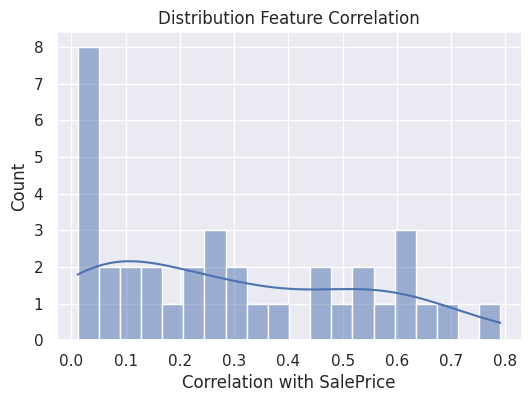

In [86]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
house_corr = train_df[numeric_cols].corr()['SalePrice'].abs().drop('SalePrice')

plt.figure(figsize=(6,4))
sns.histplot(house_corr, bins=20, kde=True)
plt.xlabel('Correlation with SalePrice')
plt.title('Distribution Feature Correlation')

plt.show()

f The features with corr > {threshold}:  ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']


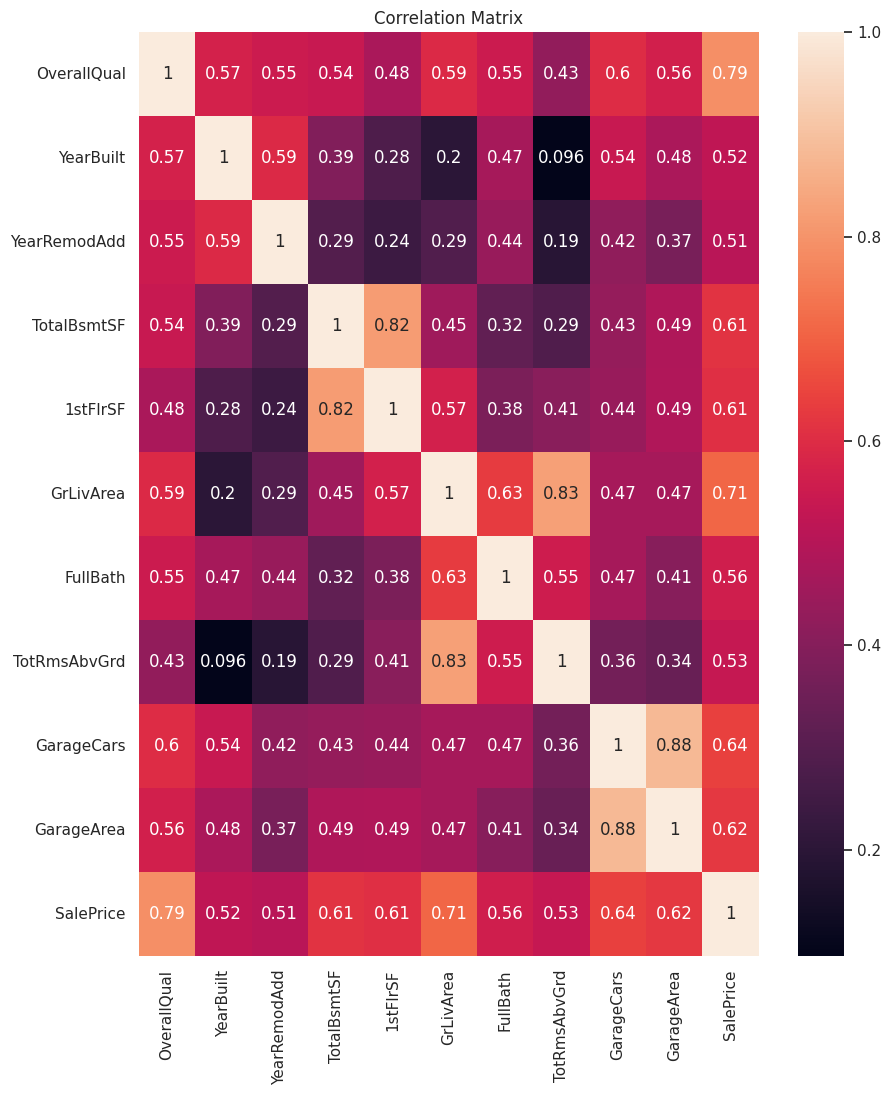

In [87]:
house_corr = train_df[numeric_cols].corr()['SalePrice'].abs().drop('SalePrice')

threshold= 0.5
strong_feats = house_corr[house_corr >= threshold].index.tolist()

print('f The features with corr > {threshold}: ',strong_feats)
plt.figure(figsize=(10,12))

sns.heatmap(train_df[strong_feats + ['SalePrice']].corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

*Plotting numerical features*

At first, based on the previous correlation matrix, I will choose some of them to see how interact with the `target` variable. In this case we have the YearBuilt, OverallQual, GarageCar, 1stFlrSF and LotArea although it doesnt appear in the matrix with high corr, but I want to check if it is related or not.
Alright, regarding the figures in the first row, we can see a consistent linear pattern; where corr >= 0.5.

* YearBuilt vs. SalePrice

*Band:* Newer houses tend to sell for more.

*Band:* Fairly narrow around the bulk of years (1950–2010), so the relationship is consistent there.

* OverallQual vs. SalePrice

*Band:* As quality rating goes up from 1→10, price climbs roughly linearly.

*Band:* Tightest around mid-range (lots of houses rated 5–8) and a bit wider at the extremes (few houses rated 1 or 10).

* GarageCars vs. SalePrice

*Band:* More garage spots → higher price on average.

*Band:* Narrow for 1–2 cars (common), wider at 3–4 cars (rarer configuration).

Regarding the second row, about the 1stFloor, is clear that bigger first floor → more expensive; but also we spotted a cluster btw 1000-2000 sq. And, with LotArea on average, larger lots sell for more, but it’s far noisier.

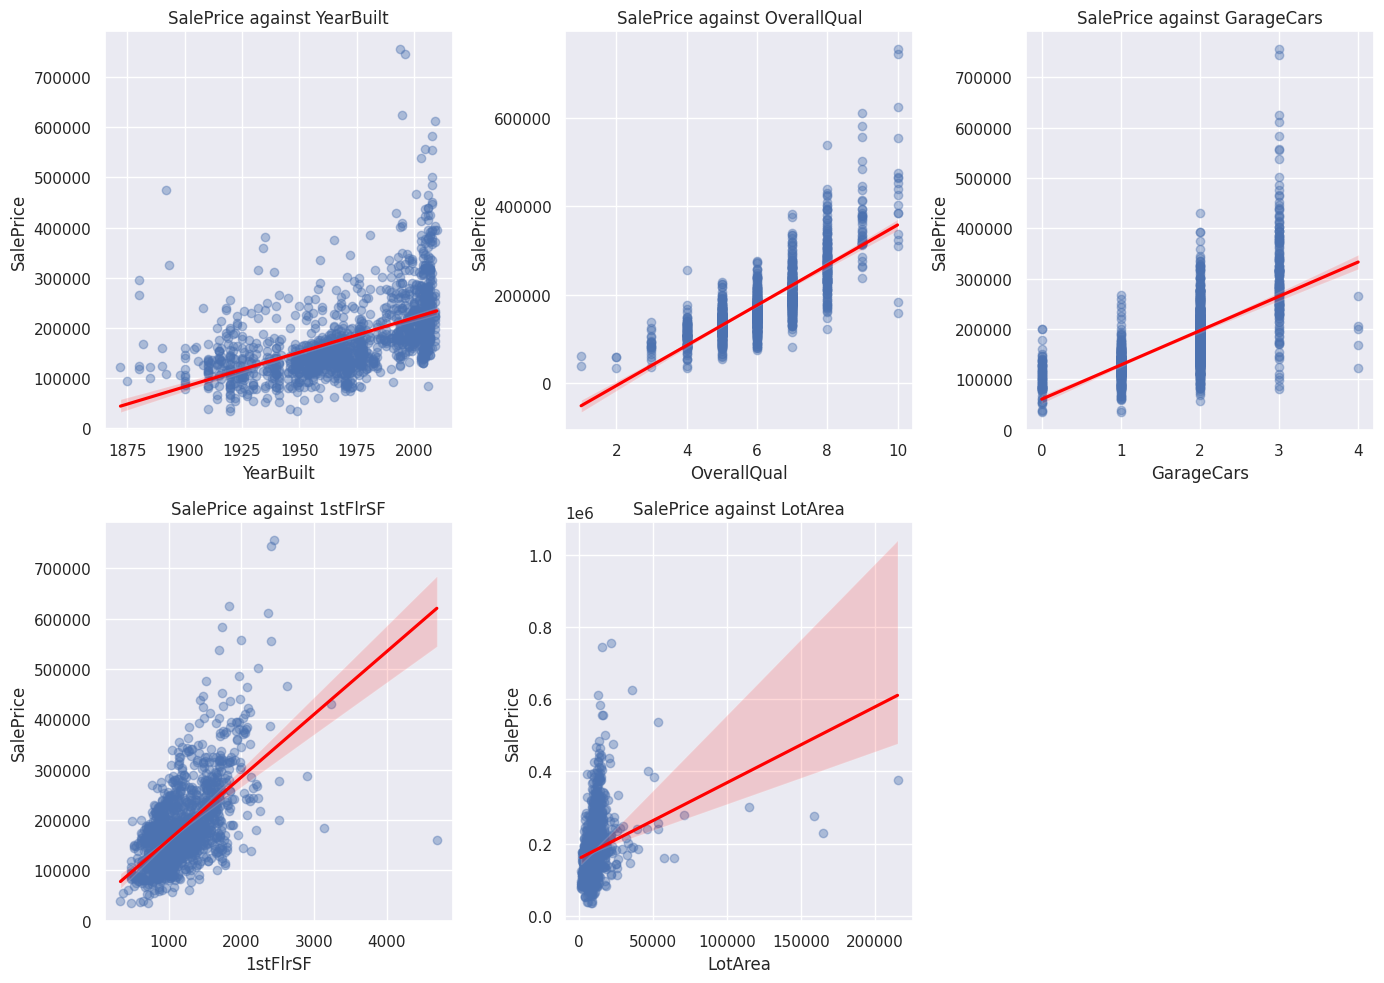

In [88]:
num_desc = ['YearBuilt','OverallQual','GarageCars','1stFlrSF','LotArea']
plt.figure(figsize=(14, 10))
sns.set(style = "darkgrid")

for i, num in enumerate(num_desc,start=1):
    ax=plt.subplot(2,3,i)

    sns.regplot(data=train_df, x=num, y='SalePrice',scatter_kws={'alpha':0.4},line_kws={'color':'red'})
    plt.title(f'SalePrice against {num}')
    plt.ylabel('SalePrice')


plt.tight_layout()
plt.show()

In [89]:
#Lets proceded to bin the variables on the second row obtained before

train_df['1stFlrSF_bin'] = pd.cut(train_df['1stFlrSF'], bins=[0,500,1000,1500,2000,2500,3000])
train_df['LotArea_bin'] = pd.cut(train_df['LotArea'], bins=[0,10000,20000,30000,40000,50000,75000,100000])

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
Mean of empty slice.
invalid value encountered in scalar divide


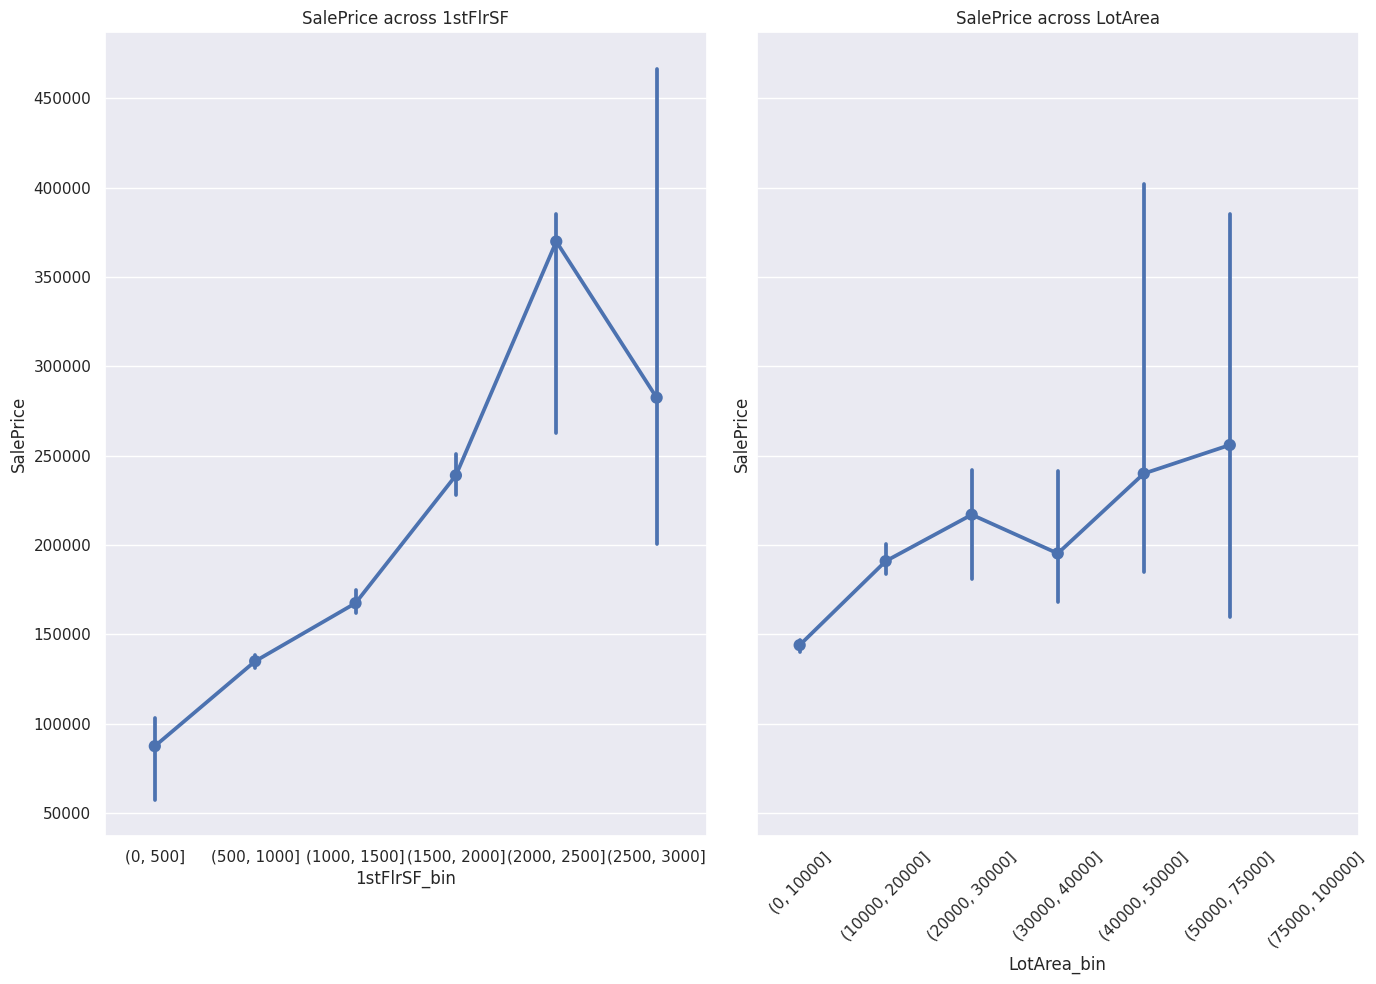

In [90]:
# 3. Plot them side by side, sharing the y‐axis

fig, axes= plt.subplots(1,2,figsize=(14,10), sharey=True)


sns.pointplot( x='1stFlrSF_bin', y='SalePrice',data=train_df,  ax=axes[0],markers='o',estimator=np.median)
axes[0].set_title('SalePrice across 1stFlrSF')
plt.xticks(rotation=45)


sns.pointplot( x='LotArea_bin', y='SalePrice',data=train_df, ax=axes[1], markers='o',estimator=np.median)
axes[1].set_title('SalePrice across LotArea')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


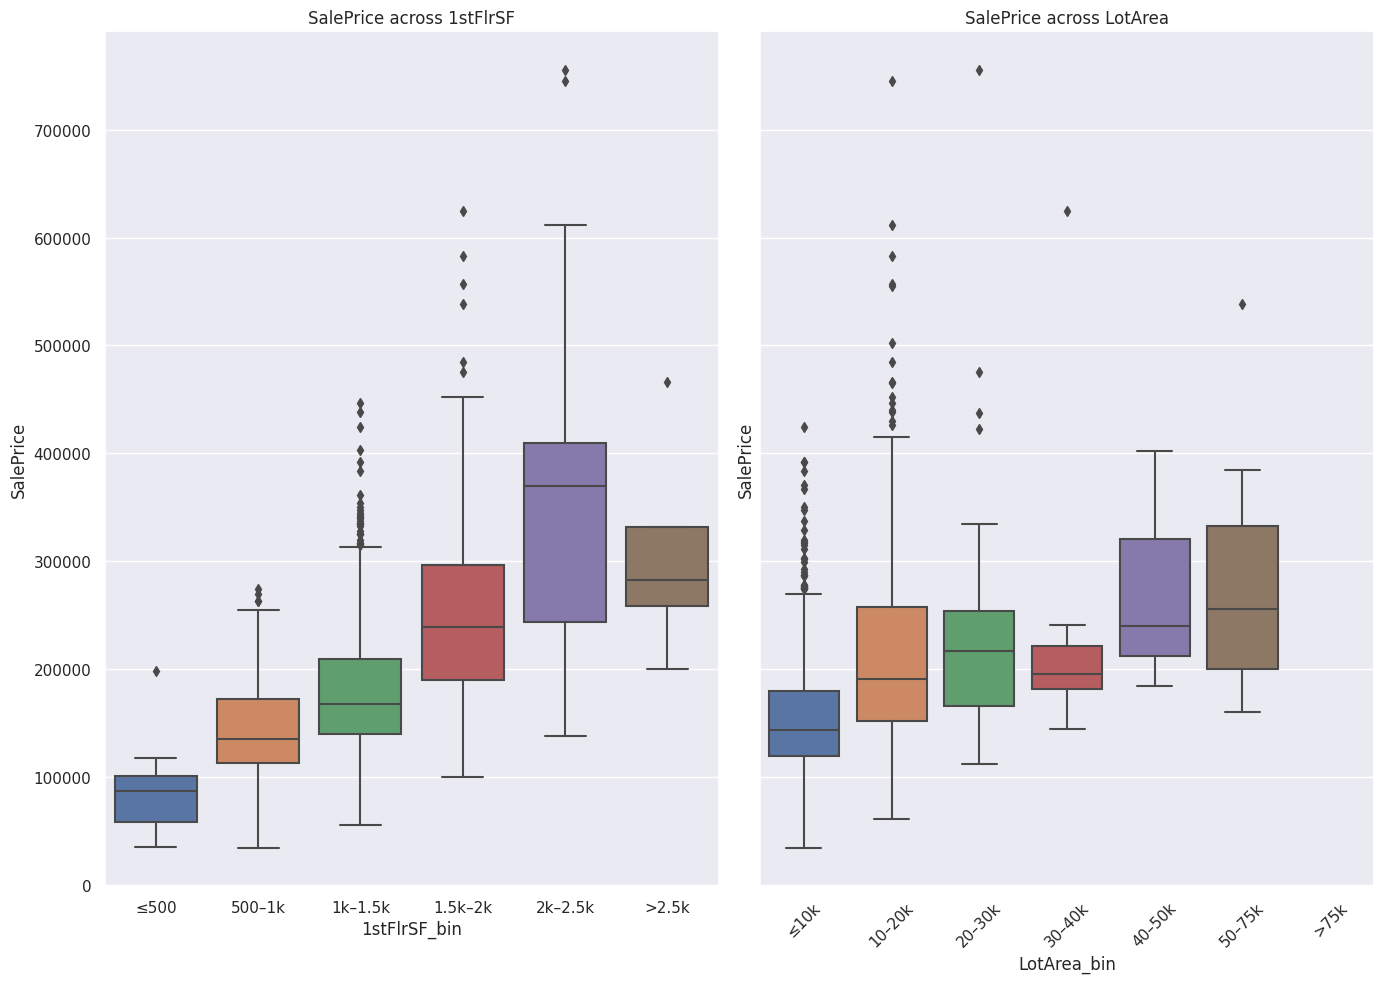

In [91]:
#Let's try a boxplot to have a better understanding of the results obtained before
bins_1 = [0,500,1000,1500,2000,2500,3000]
bins_lot = [0,10000,20000,30000,40000,50000,75000,100000]

labels_1 = ['≤500','500–1k','1k–1.5k','1.5k–2k','2k–2.5k','>2.5k']
labels_lot = ['≤10k','10–20k','20–30k','30–40k','40–50k','50–75k','>75k']

#Lets proceded to bin the variables on the second row obtained before

train_df['1stFlrSF_bin'] = pd.cut(train_df['1stFlrSF'], bins=bins_1, labels=labels_1)
train_df['LotArea_bin'] = pd.cut(train_df['LotArea'], bins=bins_lot, labels=labels_lot)

fig, axes= plt.subplots(1,2,figsize=(14,10), sharey=True)


sns.boxplot( x='1stFlrSF_bin', y='SalePrice',data=train_df,  ax=axes[0])
axes[0].set_title('SalePrice across 1stFlrSF')
plt.xticks(rotation=45)


sns.boxplot( x='LotArea_bin', y='SalePrice',data=train_df, ax=axes[1])
axes[1].set_title('SalePrice across LotArea')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

In [92]:
#Check if there is any remaining missing value in the binned process.
#It is probably that those values are above '>2.5k', so we will impute in that category

train_df[train_df['1stFlrSF_bin'].isnull()]
train_df['1stFlrSF_bin'] = train_df['1stFlrSF_bin'].fillna('>2.5k')

In [93]:
#Check if there is any remaining missing value in the binned process.
#It is probably that those values are above '>2.5k', so we will impute in that category

train_df[train_df['LotArea_bin'].isnull()]

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,1stFlrSF_bin,LotArea_bin
249,250,50,RL,<bound method Series.median of 69 81.0\n...,159000,Pave,IR2,Low,AllPub,CulDSac,...,0,0,500,6,2007,WD,Normal,277000,1k–1.5k,NaN
313,314,20,RL,150.0,215245,Pave,IR3,Low,AllPub,Inside,...,0,0,0,6,2009,WD,Normal,375000,2k–2.5k,NaN
335,336,190,RL,<bound method Series.median of 41 115.0\n...,164660,Grvl,IR1,HLS,AllPub,Corner,...,0,0,700,8,2008,WD,Normal,228950,1.5k–2k,NaN
706,707,20,RL,<bound method Series.median of 69 81.0\n...,115149,Pave,IR2,Low,AllPub,CulDSac,...,0,0,0,6,2007,WD,Normal,302000,1.5k–2k,NaN


In [94]:
train_df.loc[train_df['LotArea_bin'].isnull(), 'LotArea']
train_df['LotArea_bin'] = train_df['LotArea_bin'].fillna('>75k')

Time to jump with the categorical variables; to do that we will choose ranking by between-groups variance

In [95]:
#Just keeping those variables which has less than 10 unique values
cat_cols = [i for i in train_df.select_dtypes('object')
           if train_df[i].nunique() <= 10]

group_mean_cat = train_df.groupby(cat_cols)['SalePrice'].mean()
#create a dictionary to store the results
group_dict = {
    col: train_df.groupby(col)['SalePrice'].mean().std()
    for col in cat_cols
}

ranking_cats = pd.Series(group_dict).sort_values(ascending=False)
ranking_cats.head(5)

ExterQual      121669.389152
KitchenQual     98569.621328
BsmtQual        91276.090226
Condition2      84325.717127
RoofMatl        79783.318754
dtype: float64

In [96]:
ranking_cats.head(6)

ExterQual      121669.389152
KitchenQual     98569.621328
BsmtQual        91276.090226
Condition2      84325.717127
RoofMatl        79783.318754
FireplaceQu     76321.937251
dtype: float64

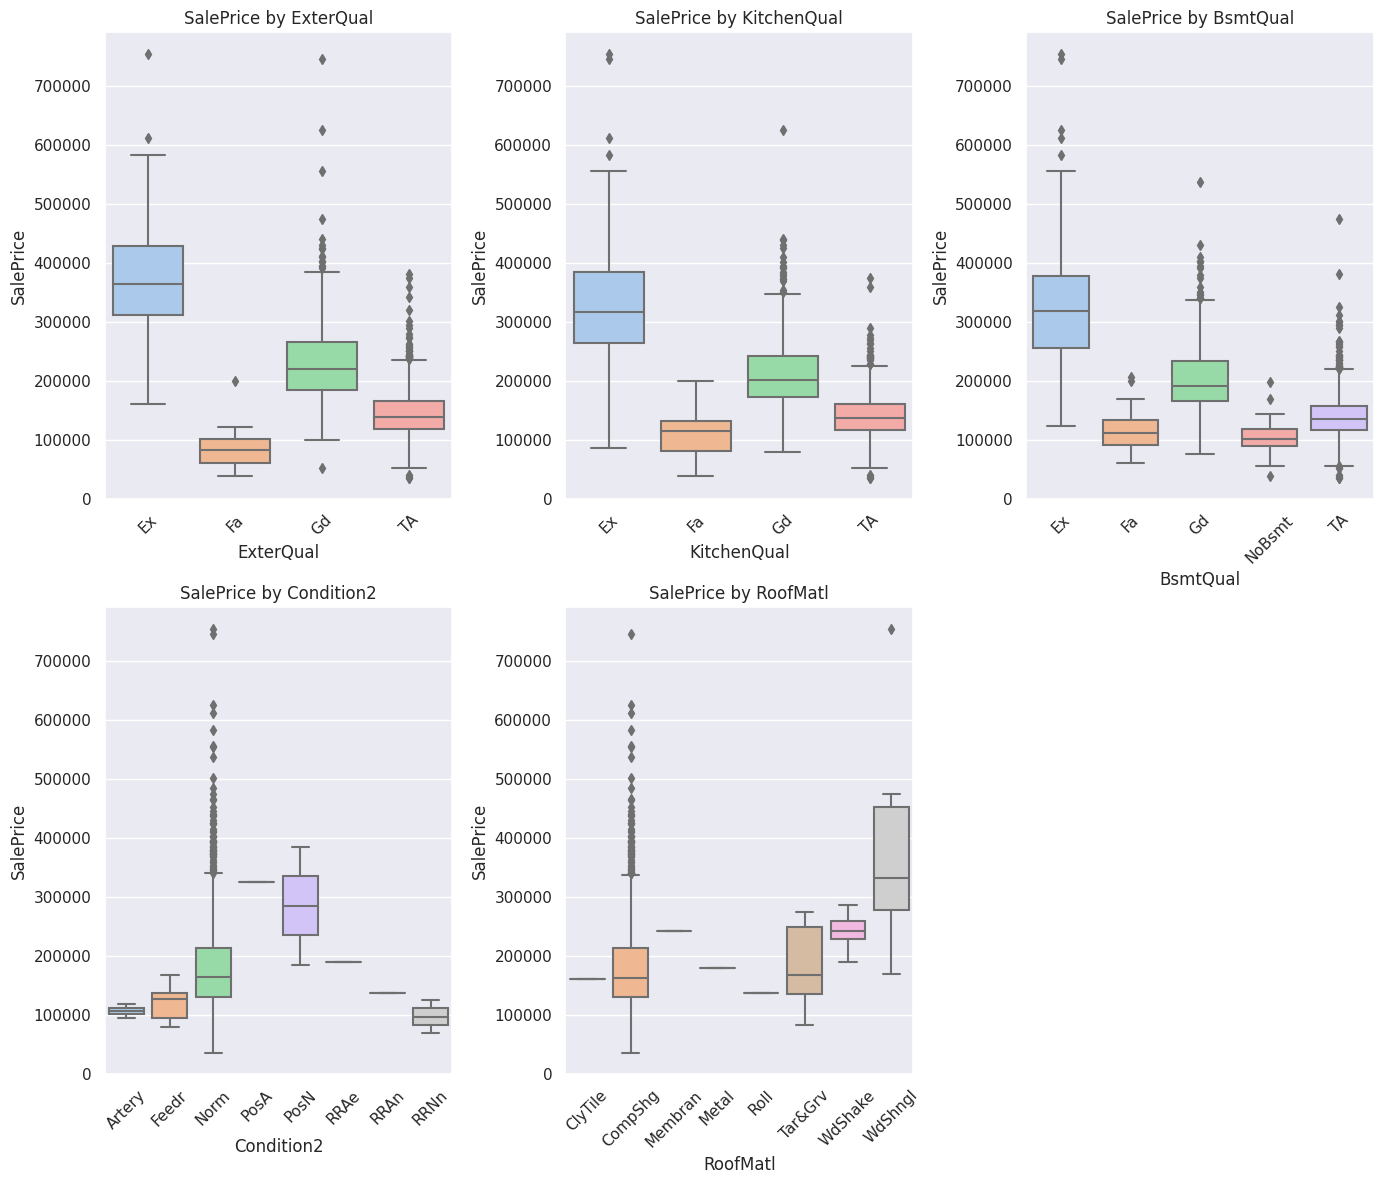

In [97]:
top5_cat = ranking_cats.head(5).index.tolist()
plt.figure(figsize=(14,12))

for i, cat in enumerate(top5_cat,1):
    ax=plt.subplot(2,3,i)
    sns.boxplot(x=cat, y='SalePrice', data= train_df,
               order= sorted(train_df[cat].unique()),
               palette='pastel')
    ax.set_title(f'SalePrice by {cat}')
    ax.tick_params(rotation=45,axis='x')

plt.tight_layout()
plt.show()

In [98]:
def map_col(count):
    mapping={
        level:(level if counts[level] > 5 else 'Other') for level in counts.index
    }

    return mapping

In [99]:
counts = train_df['Condition2'].value_counts()
train_df['Condition2_group'] = train_df['Condition2'].map(map_col(counts))

In [100]:
counts = train_df['RoofMatl'].value_counts()
train_df['RoofMatl_group'] = train_df['RoofMatl'].map(map_col(counts))

Before start with the ML models, we'll drop the variables that modified before.

In [101]:
train_df.drop(columns=['Condition2','RoofMatl','1stFlrSF','LotArea','Id'], inplace=True)

In [102]:
def metrics(y_test,y_pred):
    print("\nR2:")
    print(r2_score(y_test, y_pred))
    print("\nMAE:")
    print(mean_absolute_error(y_test, y_pred))
    print("\nMSE:")
    print(mean_squared_error(y_test, y_pred))

In [103]:
y=train_df['SalePrice']
X=train_df.loc[:, train_df.columns != 'SalePrice']

#Identify categorical variables for CatBoost
cat_columns = X.select_dtypes(include=['object','category']).columns.tolist()

for col in cat_columns:
    #X[col] = X[col].astype(str)
    #we use this new version to avoid the warning message
    X.loc[:, col] = X[col].astype(str)
    

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#Create Pool -- specially for cat variables
train_pool= Pool(data=X_train, label=y_train, cat_features=cat_columns)
test_pool= Pool(data=X_test, label=y_test, cat_features=cat_columns)

#Initialize and train model
model_cat = CatBoostRegressor(verbose=100, random_state=42)
model_cat.fit(train_pool,early_stopping_rounds=100 )
y_pred = model_cat.predict(test_pool)

metrics(y_test, y_pred)

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


Learning rate set to 0.04196
0:	learn: 75418.7391581	total: 37.4ms	remaining: 37.3s
100:	learn: 23328.8088445	total: 2.07s	remaining: 18.5s
200:	learn: 17888.2487397	total: 4.18s	remaining: 16.6s
300:	learn: 15393.2133358	total: 6.2s	remaining: 14.4s
400:	learn: 13764.8331847	total: 8.26s	remaining: 12.3s
500:	learn: 12428.6798799	total: 10.4s	remaining: 10.4s
600:	learn: 11358.9246297	total: 12.6s	remaining: 8.38s
700:	learn: 10536.8592283	total: 15.2s	remaining: 6.49s
800:	learn: 9822.4864835	total: 17.4s	remaining: 4.32s
900:	learn: 9199.2423181	total: 19.5s	remaining: 2.15s
999:	learn: 8626.0374533	total: 21.7s	remaining: 0us

R2:
0.9052425788591195

MAE:
16140.29202453574

MSE:
726820330.7023628


Alright! The idea of the next step is to take a look into a SHAP matrix, so we can understand better our model and how the variables interact with the target.
We can identify that `GrLivArea`  sits at the top. Homes with large living areas have large positive SHAP values; it means that they push the predicted price up.
Also, `OverallQual` is influential as well; high quality ratings boost price.

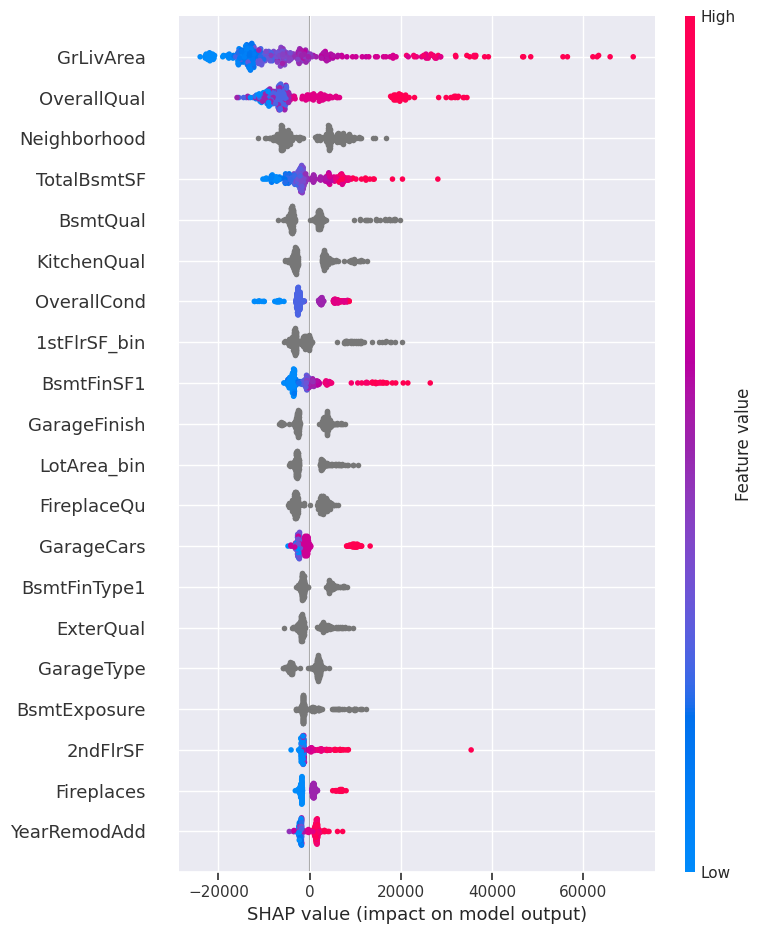

In [104]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

We could detect that maybe there is some dependence btw `TotalBsmtSF`and `BsmtFinSF1`, so we can plot a dependence-plot to check it out. 
For a given TotalBsmtSF, higher BsmtFinSF1; that tells that our model is capturing the interaction.

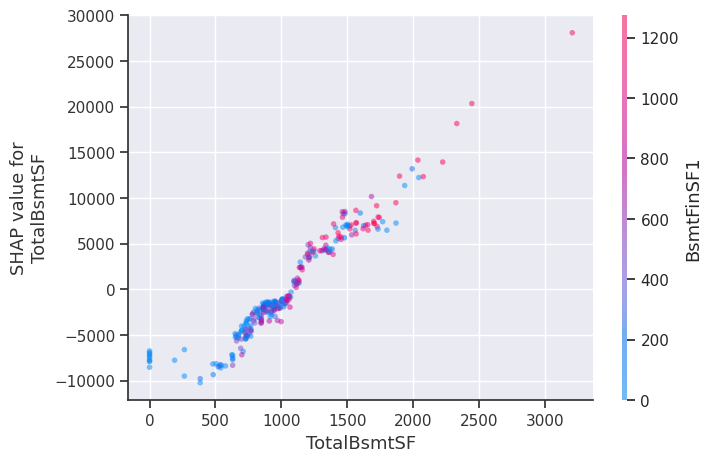

In [105]:
shap.dependence_plot(
    'TotalBsmtSF', #feature on the x-axis
    shap_values, #array from previous step
    X_test, #our df
    interaction_index='BsmtFinSF1', #color points by this feature
    alpha=0.5
    )

In [ ]:
## Hyperparameter tuning

base_model = CatBoostRegressor(
    cat_features=cat_columns,
    random_state=42,
    iterations=2000,
    od_type='Iter',
    od_wait=100,
    verbose=0  #don’t get 5×20 lots of logs.,
)

##Parameters

param_dist = {
    'learning_rate': [0.01,0.05,0.1,0.2],
    'depth': [4,6,8],
    'l2_leaf_reg': [1,3,5,7,9],
    'iterations': [500,1000,1500]
    
}

## Create score

rmse_scorer = make_scorer(
    mean_squared_error,
    greater_is_better=False,
    squared=False
)

## RandomizedSearch

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train,y_train)

print('Best RMSE: ', search.best_score_)
print('Best hyperparameter: ', search.best_params_)

In [ ]:
joblib.dump(search, 'catboost_search.pkl')

In [106]:
search = joblib.load('catboost_search.pkl')

In [107]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

In [108]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE:  {mae:.2f}")
print(f"Test R²:   {r2:.4f}")

Test RMSE: 26737.05
Test MAE:  16175.95
Test R²:   0.9068


We can identify that we reduced RMSE about 3000-points. Next stop is using Cross-Validation to check if we can get an improvement of the metrics.

In [109]:
# 1) Create an RMSE scorer
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

best_model = search.best_estimator_

# 3) Run 5-fold CV on the full training set
scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1
)

# 4) Convert to positive RMSE and summarize
rmse_scores = -scores
print(f"5-Fold CV RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")

5-Fold CV RMSE: 25753.08 ± 3556.48


As we obtained better results with hyperparameter instead ; the next step is to re-fit the final model

In [110]:
final_model = CatBoostRegressor(
    **search.best_params_,
    cat_features= cat_columns,
    random_state=42,
    verbose=0
    
)

final_model.fit(X_train,y_train)

In [111]:
## Check residuals

y_pred_test = final_model.predict(X_test)
residuals = y_test-y_pred_test

In the following plots, we can identify that the Residual Distribution follows a Gaussian distribution, the peek of observations sits around zero; which tell us that most errors are small.
On the other hand, the scatterplot the dense cloud of points are around the zero line with a margin +- 50000 of the prediction.

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


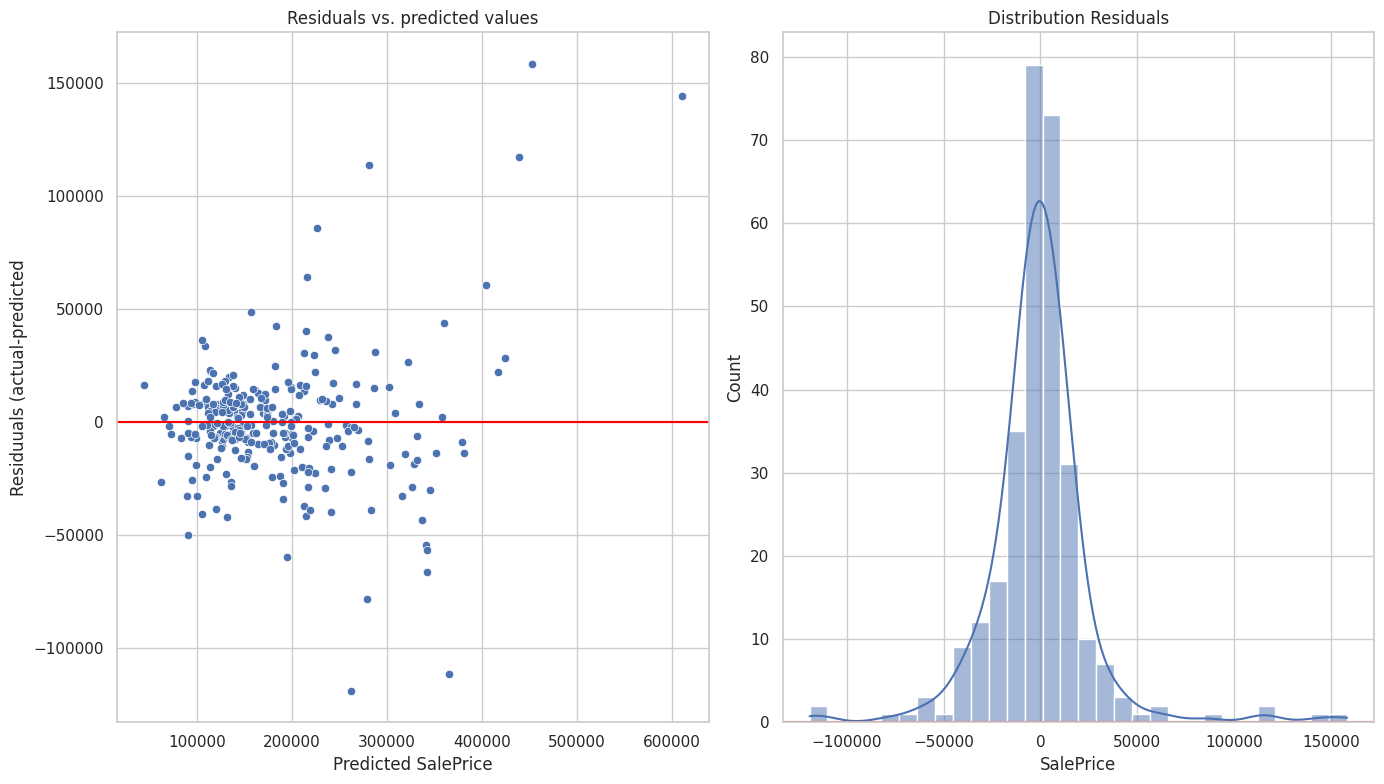

In [112]:
#set style
sns.set(style = "whitegrid")

fig, axes= plt.subplots(1,2,figsize=(14,8))
#residuals vs predicted
ax=axes[0]
sns.scatterplot(x=y_pred, y=residuals, ax=ax)
ax.axhline(0, color='red', linestyle='-')
ax.set_xlabel('Predicted SalePrice')
ax.set_ylabel('Residuuals (actual-predicted')
ax.set_title('Residuals vs. predicted values')

#residual distribution
ax=axes[1]
sns.histplot(residuals,bins=30,kde=True, ax=ax)
ax.axhline(0, color='red', linestyle='-')
ax.set_label('Residual')
ax.set_title('Distribution Residuals')


plt.tight_layout()
plt.show()

Next step is to align our test_df with the changes applied before in the train_df before make the predictions.

In [113]:
test_df.drop(columns=['PoolQC','MiscFeature','Alley','Fence'],inplace=True)

bsmt_col=['BsmtExposure','BsmtFinType2','BsmtQual', 'BsmtCond','BsmtFinType1']
for col in bsmt_col:
    test_df[col].fillna('NoBsmt',inplace=True)

garage_col=['GarageType','GarageFinish','GarageQual', 'GarageCond']
for col in garage_col:
    test_df[col].fillna('NoGarage',inplace=True)

test_df['FireplaceQu'] = test_df['FireplaceQu'].fillna('NoFireplace')
test_df['MasVnrType'] = test_df['MasVnrType'].fillna('None')
test_df['Electrical'] = test_df['Electrical'].fillna(test_df['Electrical'].mode()[0])

test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(0)
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(0)

test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median))

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [114]:
#Let's try a boxplot to have a better understanding of the results obtained before
bins_1 = [0,500,1000,1500,2000,2500,3000]
bins_lot = [0,10000,20000,30000,40000,50000,75000,100000]

labels_1 = ['≤500','500–1k','1k–1.5k','1.5k–2k','2k–2.5k','>2.5k']
labels_lot = ['≤10k','10–20k','20–30k','30–40k','40–50k','50–75k','>75k']

#Lets proceded to bin the variables on the second row obtained before

test_df['1stFlrSF_bin'] = pd.cut(test_df['1stFlrSF'], bins=bins_1, labels=labels_1)
test_df['LotArea_bin'] = pd.cut(test_df['LotArea'], bins=bins_lot, labels=labels_lot)

test_df['1stFlrSF_bin'] = test_df['1stFlrSF_bin'].fillna('>2.5k')
test_df['LotArea_bin'] = test_df['LotArea_bin'].fillna('>75k')

counts = test_df['Condition2'].value_counts()
test_df['Condition2_group'] = test_df['Condition2'].map(map_col(counts))

counts = test_df['RoofMatl'].value_counts()
test_df['RoofMatl_group'] = test_df['RoofMatl'].map(map_col(counts))
test_df.drop(columns=['Condition2','RoofMatl','1stFlrSF','LotArea'], inplace=True)


In [115]:
missing_values = test_df.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

MSZoning        4
BsmtHalfBath    2
BsmtFullBath    2
Utilities       2
Functional      2
TotalBsmtSF     1
GarageArea      1
Exterior2nd     1
Exterior1st     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
KitchenQual     1
SaleType        1
GarageCars      1
dtype: int64


In [116]:
missing_col = test_df.columns[test_df.isnull().sum() >0]
test_df[missing_col].info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSZoning      1455 non-null   object 
 1   Utilities     1457 non-null   object 
 2   Exterior1st   1458 non-null   object 
 3   Exterior2nd   1458 non-null   object 
 4   BsmtFinSF1    1458 non-null   float64
 5   BsmtFinSF2    1458 non-null   float64
 6   BsmtUnfSF     1458 non-null   float64
 7   TotalBsmtSF   1458 non-null   float64
 8   BsmtFullBath  1457 non-null   float64
 9   BsmtHalfBath  1457 non-null   float64
 10  KitchenQual   1458 non-null   object 
 11  Functional    1457 non-null   object 
 12  GarageCars    1458 non-null   float64
 13  GarageArea    1458 non-null   float64
 14  SaleType      1458 non-null   object 
dtypes: float64(8), object(7)
memory usage: 701.1 KB


We can identify that some of the features has some missing values, so before predict them we need to handle them. It is probable that all the variables related with Basement comes with Nan, because they don't have one; so as we see in the next stept looking for BsmtExposure(previously imputed with 'NoBsmt'; we proceed to do the same.

In [117]:
test_df[test_df['BsmtFullBath'].isnull()]['BsmtExposure']

660    NoBsmt
728    NoBsmt
Name: BsmtExposure, dtype: object

In [118]:
bsmt_col=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF','BsmtFullBath','BsmtHalfBath']
for col in bsmt_col:
    test_df[col].fillna(0,inplace=True)

garage_col=['GarageCars','GarageArea']
for col in garage_col:
    test_df[col].fillna(0,inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [119]:
remaining_cols=['MSZoning','Utilities','Functional','Exterior2nd','Exterior1st','SaleType','KitchenQual']
for col in remaining_cols:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

In [120]:
#Identify categorical variables for CatBoost
cat_columns = test_df.select_dtypes(include=['object','category']).columns.tolist()

for col in cat_columns:
    #X[col] = X[col].astype(str)
    #we use this new version to avoid the warning message
    test_df.loc[:, col] = test_df[col].astype(str)

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


In [121]:
Id = test_df['Id']
test_df.drop(columns=['Id'], axis=1, inplace=True)

In [122]:
y_pred_f = final_model.predict(test_df)

In [123]:
submission = pd.DataFrame({
    'Id': Id,  
    'SalePrice': y_pred_f.astype(float)       
})

submission.to_csv('/kaggle/working/submission.csv', index=False)

In [124]:
!zip -j submission.zip /kaggle/working/submission.csv

updating: submission.csv (deflated 49%)


In [125]:
from IPython.display import HTML
HTML('<a href="submission.zip" download style="font-size:20px">⬇️ Download submission.zip</a>')